In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR, PolynomialLR

import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger

import wandb

from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.service.utils.report_utils import exp_to_df
from ax.utils.notebook.plotting import init_notebook_plotting, render

import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [2]:
L.seed_everything(8407)

Seed set to 8407


8407

## Data Generation

In [3]:
def f(x, p):
    return p[0] * torch.exp(-x / p[1]) + p[2] * x * torch.exp(-x / p[3])

In [4]:
noise  = torch.normal(0.0, 0.5, (1000,))
p_true = [20.0, 10.0, 1.0, 50.0]
x      = torch.linspace(0, 100, 1000)
y      = f(x, p_true) + noise

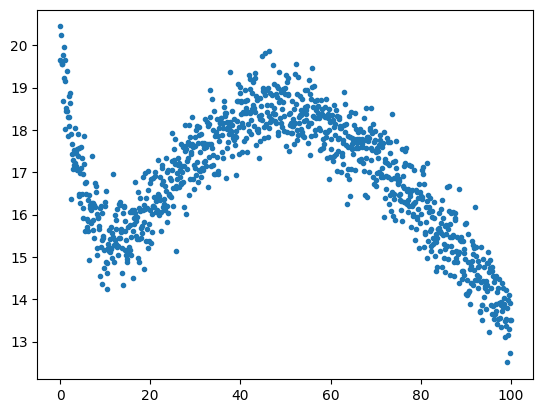

In [5]:
plt.plot(x, y, '.')
plt.show()

In [6]:
df = torch.column_stack([x, y])
df

tensor([[  0.0000,  19.6547],
        [  0.1001,  20.4463],
        [  0.2002,  19.6204],
        ...,
        [ 99.7998,  13.4994],
        [ 99.8999,  13.9078],
        [100.0000,  13.5103]])

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

print(df_train.shape)
print(df_test.shape)

torch.Size([800, 2])
torch.Size([200, 2])


In [8]:
_, ics_train = torch.sort(df_train[:,0])
_, ics_test  = torch.sort(df_test[:,0])

In [9]:
df_train = df_train[ics_train]
df_test  = df_test[ics_test]

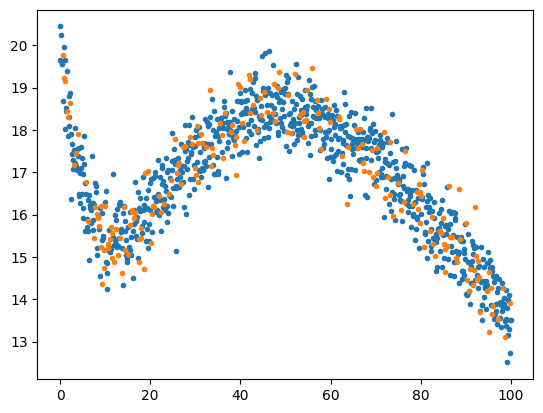

In [10]:
plt.plot(df_train[:,0], df_train[:,1], '.')
plt.plot(df_test[:,0], df_test[:,1], '.')
plt.show()

In [11]:
scaler = RobustScaler()

scaler.fit(df_train)

df_train = scaler.transform(df_train)
df_test  = scaler.transform(df_test)

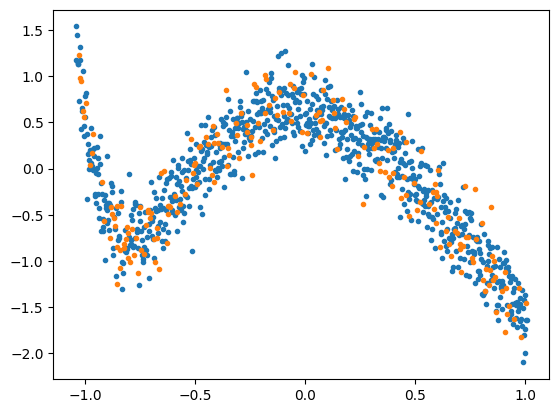

In [12]:
plt.plot(df_train[:,0], df_train[:,1], '.')
plt.plot(df_test[:,0], df_test[:,1], '.')
plt.show()

In [13]:
class NoisyData(Dataset):
    def __init__(self, df):
        x = df[:,0]
        y = df[:,1]
        self.x = torch.tensor(x, dtype=torch.float32).reshape((-1,1))
        self.y = torch.tensor(y, dtype=torch.float32).reshape((-1,1))

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [14]:
ds_train = NoisyData(df_train)
ds_test  = NoisyData(df_test)

In [15]:
ds_train[:10]

(tensor([[-1.0410],
         [-1.0390],
         [-1.0369],
         [-1.0349],
         [-1.0328],
         [-1.0308],
         [-1.0267],
         [-1.0246],
         [-1.0205],
         [-1.0164]]),
 tensor([[1.1752],
         [1.5377],
         [1.1594],
         [1.4434],
         [1.1302],
         [1.1319],
         [0.7282],
         [1.3145],
         [1.1783],
         [0.4304]]))

## Construct MLP

In [16]:
class MLP(L.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.lr          = hparams['learning_rate']
        self.batch       = hparams['batch_size']
        self.hidden_size = hparams['hidden_size']
        self.num_layers  = hparams['num_layers']
        self.epochs      = hparams['epochs']

        self.save_hyperparameters()

        net = []
        net.extend([
            nn.Linear(1, self.hidden_size),
            nn.GELU(approximate='tanh'),
        ])
        for _ in range(self.num_layers):
            net.extend([
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.GELU(approximate='tanh'),
            ])
        net.append(nn.Linear(self.hidden_size, 1))
        self.net = nn.Sequential(*net)
        self.loss_fn = nn.MSELoss()
    
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y, y_hat)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y, y_hat)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
            # "lr_scheduler": {
            #     "scheduler": OneCycleLR(
            #         optimizer,
            #         max_lr = self.lr,
            #         epochs = self.epochs,
            #         steps_per_epoch = len(ds_train) // self.batch + 1,
            #     ),
            #     "interval": "step",
            #     "monitor": "val_loss",
            #     "strict": True,
            # }
            "lr_scheduler": {
                "scheduler": PolynomialLR(
                    optimizer,
                    total_iters = self.epochs,
                    power = 2.0
                ),
                "interval": "epoch",
                "monitor": "val_loss",
                "strict": True,
            }
        }

In [17]:
def evaluate_mlp(parameters):
    hparams = {
        'learning_rate': parameters.get('lr', 1e-2),
        'batch_size': parameters.get('batch_size', 32),
        'epochs': parameters.get('epochs', 500),
        'hidden_size': parameters.get('hidden_size', 16),
        'num_layers': parameters.get('num_layers', 4)
    }

    dl_train = DataLoader(ds_train, batch_size=hparams['batch_size'], shuffle=True)
    dl_test  = DataLoader(ds_test, batch_size=hparams['batch_size'], shuffle=False)

    model = MLP(hparams)

    wandb_logger = WandbLogger(
        project="Ax_tutorial"  
    )

    trainer = Trainer(
        logger = wandb_logger,
        max_epochs = hparams['epochs'],
        devices=[0],
        accelerator='auto',
        enable_progress_bar=False,
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"),
        ]
    )

    trainer.fit(model, dl_train, dl_test)

    wandb.finish()

    x_test, y_test = ds_test[:]
    x_test = x_test.to(model.device)
    y_test = y_test.to(model.device)

    y_hat  = model(x_test)
    loss   = F.mse_loss(y_hat, y_test)
    return loss.item()

## Hyperparameter Tuning

In [18]:
ax_client = AxClient()

[INFO 03-01 17:52:00] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [19]:
ax_client.create_experiment(
    name="MLP-Tuning",
    parameters=[
        {
            "name": 'lr',
            "type": 'range',
            "bounds": [1e-3, 1e-1],
            "log_scale": True,
        },
        {
            "name": 'batch_size',
            "type": 'choice',
            "values": [16, 32, 64, 128],
        },
        {
            "name": 'epochs',
            "type": 'fixed',
            "value": 500,
        },
        {
            "name": 'hidden_size',
            "type": 'choice',
            "values": [8, 16, 32],
        },
        {
            "name": 'num_layers',
            "type": 'range',
            "bounds": [2, 5],
            "value_type": "int",
        }
    ],
    objectives={"evaluate_mlp": ObjectiveProperties(minimize=True)},
)

[INFO 03-01 17:52:00] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-01 17:52:00] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/ax/core/parameter.py:518: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "batch_size". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/ax/core/parameter.py:518: UserWa

In [20]:
for _ in range(20):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate_mlp(parameters))

[INFO 03-01 17:52:00] ax.service.ax_client: Generated new trial 0 with parameters {'lr': 0.043404, 'batch_size': 128, 'hidden_size': 8, 'num_layers': 5, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 4GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 385   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
385       Trainable params
0         Non-trainable params
385       Total params
0.002     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:52:15] ax.service.ax_client: Completed trial 0 with data: {'evaluate_mlp': (0.060985, None)}.
[INFO 03-01 17:52:15] ax.service.ax_client: Generated new trial 1 with parameters {'lr': 0.039524, 'batch_size': 64, 'hidden_size': 32, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:52:32] ax.service.ax_client: Completed trial 1 with data: {'evaluate_mlp': (0.061132, None)}.
[INFO 03-01 17:52:32] ax.service.ax_client: Generated new trial 2 with parameters {'lr': 0.002156, 'batch_size': 16, 'hidden_size': 16, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.1 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.005     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:53:20] ax.service.ax_client: Completed trial 2 with data: {'evaluate_mlp': (0.060211, None)}.
[INFO 03-01 17:53:20] ax.service.ax_client: Generated new trial 3 with parameters {'lr': 0.070062, 'batch_size': 128, 'hidden_size': 8, 'num_layers': 3, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 241   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:53:33] ax.service.ax_client: Completed trial 3 with data: {'evaluate_mlp': (0.060276, None)}.
[INFO 03-01 17:53:33] ax.service.ax_client: Generated new trial 4 with parameters {'lr': 0.036923, 'batch_size': 64, 'hidden_size': 16, 'num_layers': 2, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 593   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
593       Trainable params
0         Non-trainable params
593       Total params
0.002     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:53:50] ax.service.ax_client: Completed trial 4 with data: {'evaluate_mlp': (0.060865, None)}.
[INFO 03-01 17:53:50] ax.service.ax_client: Generated new trial 5 with parameters {'lr': 0.071234, 'batch_size': 64, 'hidden_size': 32, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:54:10] ax.service.ax_client: Completed trial 5 with data: {'evaluate_mlp': (0.0615, None)}.
[INFO 03-01 17:54:10] ax.service.ax_client: Generated new trial 6 with parameters {'lr': 0.001701, 'batch_size': 16, 'hidden_size': 16, 'num_layers': 3, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 865   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
865       Trainable params
0         Non-trainable params
865       Total params
0.003     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:54:55] ax.service.ax_client: Completed trial 6 with data: {'evaluate_mlp': (0.060254, None)}.
[INFO 03-01 17:54:55] ax.service.ax_client: Generated new trial 7 with parameters {'lr': 0.046713, 'batch_size': 32, 'hidden_size': 16, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.1 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.005     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:55:22] ax.service.ax_client: Completed trial 7 with data: {'evaluate_mlp': (0.06135, None)}.
[INFO 03-01 17:55:23] ax.service.ax_client: Generated new trial 8 with parameters {'lr': 0.001, 'batch_size': 16, 'hidden_size': 16, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.1 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.005     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:56:07] ax.service.ax_client: Completed trial 8 with data: {'evaluate_mlp': (0.06017, None)}.
[INFO 03-01 17:56:08] ax.service.ax_client: Generated new trial 9 with parameters {'lr': 0.00122, 'batch_size': 16, 'hidden_size': 32, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:56:50] ax.service.ax_client: Completed trial 9 with data: {'evaluate_mlp': (0.059998, None)}.
[INFO 03-01 17:56:51] ax.service.ax_client: Generated new trial 10 with parameters {'lr': 0.00107, 'batch_size': 32, 'hidden_size': 32, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:57:19] ax.service.ax_client: Completed trial 10 with data: {'evaluate_mlp': (0.060315, None)}.
[INFO 03-01 17:57:20] ax.service.ax_client: Generated new trial 11 with parameters {'lr': 0.001104, 'batch_size': 16, 'hidden_size': 32, 'num_layers': 5, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 5.4 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:58:08] ax.service.ax_client: Completed trial 11 with data: {'evaluate_mlp': (0.060068, None)}.
[INFO 03-01 17:58:10] ax.service.ax_client: Generated new trial 12 with parameters {'lr': 0.001, 'batch_size': 16, 'hidden_size': 32, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:59:02] ax.service.ax_client: Completed trial 12 with data: {'evaluate_mlp': (0.060111, None)}.
[INFO 03-01 17:59:04] ax.service.ax_client: Generated new trial 13 with parameters {'lr': 0.00189, 'batch_size': 16, 'hidden_size': 32, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 17:59:49] ax.service.ax_client: Completed trial 13 with data: {'evaluate_mlp': (0.060034, None)}.
[INFO 03-01 17:59:50] ax.service.ax_client: Generated new trial 14 with parameters {'lr': 0.08972, 'batch_size': 128, 'hidden_size': 8, 'num_layers': 2, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 169   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 18:00:03] ax.service.ax_client: Completed trial 14 with data: {'evaluate_mlp': (0.060611, None)}.
[INFO 03-01 18:00:05] ax.service.ax_client: Generated new trial 15 with parameters {'lr': 0.001508, 'batch_size': 16, 'hidden_size': 32, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 18:00:51] ax.service.ax_client: Completed trial 15 with data: {'evaluate_mlp': (0.059927, None)}.
[INFO 03-01 18:00:54] ax.service.ax_client: Generated new trial 16 with parameters {'lr': 0.1, 'batch_size': 16, 'hidden_size': 8, 'num_layers': 2, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 169   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 18:01:43] ax.service.ax_client: Completed trial 16 with data: {'evaluate_mlp': (0.060994, None)}.
[INFO 03-01 18:01:44] ax.service.ax_client: Generated new trial 17 with parameters {'lr': 0.03916, 'batch_size': 128, 'hidden_size': 8, 'num_layers': 3, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 241   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 18:01:58] ax.service.ax_client: Completed trial 17 with data: {'evaluate_mlp': (0.060944, None)}.
[INFO 03-01 18:01:59] ax.service.ax_client: Generated new trial 18 with parameters {'lr': 0.001469, 'batch_size': 16, 'hidden_size': 32, 'num_layers': 4, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 18:02:46] ax.service.ax_client: Completed trial 18 with data: {'evaluate_mlp': (0.060605, None)}.
[INFO 03-01 18:02:47] ax.service.ax_client: Generated new trial 19 with parameters {'lr': 0.00146, 'batch_size': 16, 'hidden_size': 16, 'num_layers': 5, 'epochs': 500}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.4 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

[INFO 03-01 18:03:38] ax.service.ax_client: Completed trial 19 with data: {'evaluate_mlp': (0.059949, None)}.


In [21]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters

{'lr': 0.0014596958532696405,
 'batch_size': 16,
 'hidden_size': 16,
 'num_layers': 5,
 'epochs': 500}

In [22]:
ax_client.generation_strategy.trials_as_df

[INFO 03-01 18:04:33] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0   GenerationStep_0            Sobol            0    COMPLETED   
1   GenerationStep_0            Sobol            1    COMPLETED   
2   GenerationStep_0            Sobol            2    COMPLETED   
3   GenerationStep_0            Sobol            3    COMPLETED   
4   GenerationStep_0            Sobol            4    COMPLETED   
5   GenerationStep_0            Sobol            5    COMPLETED   
6   GenerationStep_0            Sobol            6    COMPLETED   
7   GenerationStep_0            Sobol            7    COMPLETED   
8   GenerationStep_1          BoTorch            8    COMPLETED   
9   GenerationStep_1          BoTorch            9    COMPLETED   
10  GenerationStep_1          BoTorch           10    COMPLETED   
11  GenerationStep_1          BoTorch           11    COMPLETED   
12  GenerationStep_1          BoTorch           12    COMPLETED   
13  GenerationStep_1          BoTorch           13    COMPLETED   
14  GenerationStep_1          BoTorch           14    COMPLETED   
15  GenerationStep_1          BoTorch           15    COMPLETED   
16  GenerationStep_1          BoTorch           16    COMPLETED   
17  GenerationStep_1          BoTorch           17    COMPLETED   
18  GenerationStep_1          BoTorch           18    COMPLETED   
19  GenerationStep_1          BoTorch           19    COMPLETED   

                                Arm Parameterizations  
0   {'0_0': {'lr': 0.04, 'batch_size': 128, 'hidde...  
1   {'1_0': {'lr': 0.04, 'batch_size': 64, 'hidden...  
2   {'2_0': {'lr': 0.0, 'batch_size': 16, 'hidden_...  
3   {'3_0': {'lr': 0.07, 'batch_size': 128, 'hidde...  
4   {'4_0': {'lr': 0.04, 'batch_size': 64, 'hidden...  
5   {'5_0': {'lr': 0.07, 'batch_size': 64, 'hidden...  
6   {'6_0': {'lr': 0.0, 'batch_size': 16, 'hidden_...  
7   {'7_0': {'lr': 0.05, 'batch_size': 32, 'hidden...  
8   {'8_0': {'lr': 0.0, 'batch_size': 16, 'hidden_...  
9   {'9_0': {'lr': 0.0, 'batch_size': 16, 'hidden_...  
10  {'10_0': {'lr': 0.0, 'batch_size': 32, 'hidden...  
11  {'11_0': {'lr': 0.0, 'batch_size': 16, 'hidden...  
12  {'12_0': {'lr': 0.0, 'batch_size': 16, 'hidden...  
13  {'13_0': {'lr': 0.0, 'batch_size': 16, 'hidden...  
14  {'14_0': {'lr': 0.09, 'batch_size': 128, 'hidd...  
15  {'15_0': {'lr': 0.0, 'batch_size': 16, 'hidden...  
16  {'16_0': {'lr': 0.1, 'batch_size': 16, 'hidden...  
17  {'17_0': {'lr': 0.04, 'batch_size': 128, 'hidd...  
18  {'18_0': {'lr': 0.0, 'batch_size': 16, 'hidden...  
19  {'19_0': {'lr': 0.0, 'batch_size': 16, 'hidden...

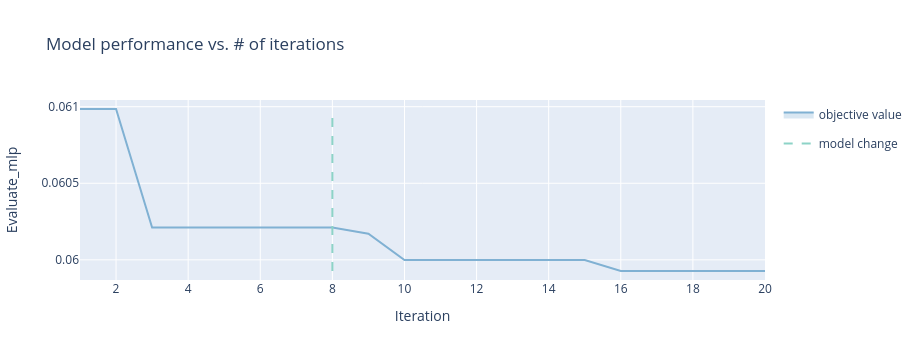

In [24]:
render(ax_client.get_optimization_trace())

In [25]:
ax_client.get_best_trial()

(19,
 {'lr': 0.0014596958532696405,
  'batch_size': 16,
  'hidden_size': 16,
  'num_layers': 5,
  'epochs': 500},
 ({'evaluate_mlp': 0.06009587224645431},
  {'evaluate_mlp': {'evaluate_mlp': 2.440514897611008e-08}}))

In [26]:
from ax.plot.scatter import interact_fitted, plot_objective_vs_constraints, tile_fitted
from ax.plot.slice import plot_slice

In [27]:
model = ax_client.generation_strategy.model

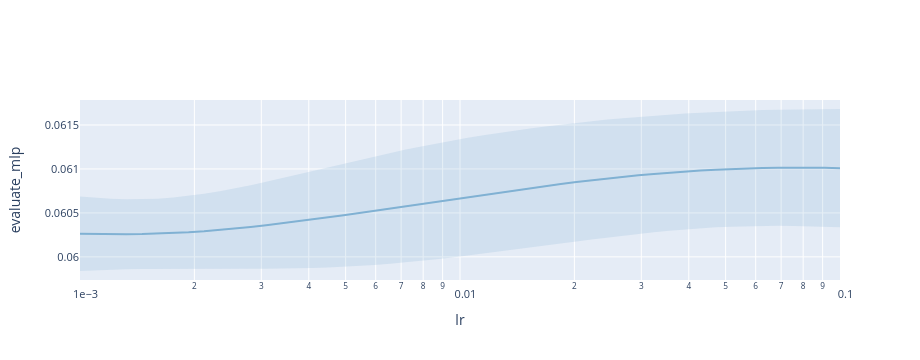

In [29]:
render(plot_slice(model, "lr", "evaluate_mlp"))

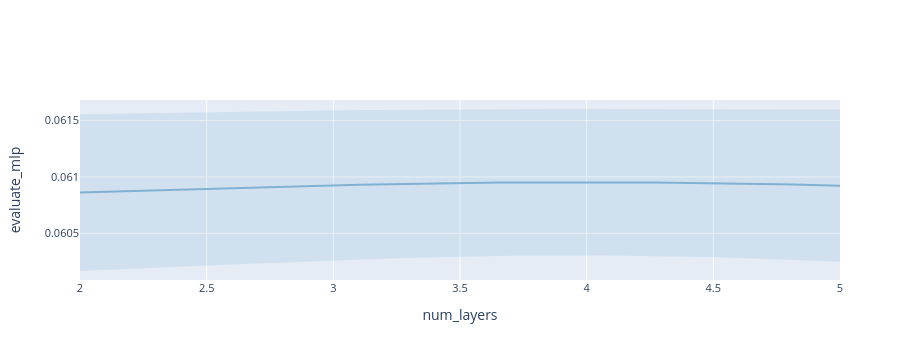

In [31]:
render(plot_slice(model, "num_layers", "evaluate_mlp"))

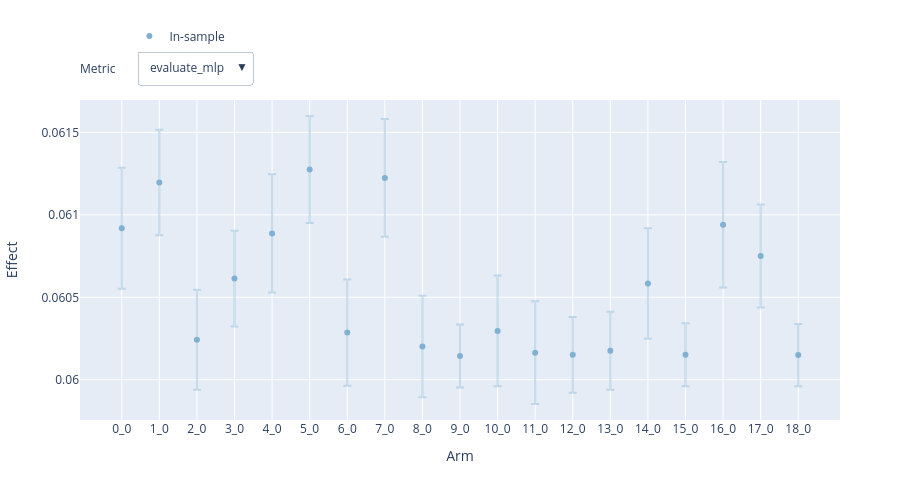

In [32]:
render(interact_fitted(model, rel=False))

## Test for best model

In [44]:
import numpy as np

In [45]:
best_param, _ = ax_client.get_best_parameters()
hparams = {
    'learning_rate': best_param.get('lr', 1e-2),
    'batch_size': best_param.get('batch_size', 32),
    'epochs': best_param.get('epochs', 500),
    'hidden_size': best_param.get('hidden_size', 16),
    'num_layers': best_param.get('num_layers', 4)
}

In [48]:
dl_train = DataLoader(ds_train, batch_size=hparams['batch_size'], shuffle=True)
dl_test  = DataLoader(ds_test, batch_size=hparams['batch_size'], shuffle=False)

In [49]:
model = MLP(hparams=hparams)

wandb_logger = WandbLogger(
    project="Ax_tutorial"  
)

trainer = Trainer(
    logger = wandb_logger,
    max_epochs = hparams['epochs'],
    devices=[0],
    accelerator='auto',
    enable_progress_bar=False,
    callbacks=[
        LearningRateMonitor(logging_interval="epoch"),
    ]
)

trainer.fit(model, dl_train, dl_test)

wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.4 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=500` reached.


In [50]:
def decoder(model, dl):
    x_input = []
    y_input = []
    y_output = []

    for x, y in dl:
        x_input.extend(x.flatten())
        y_input.extend(y.flatten())

        x = x.to(model.device)
        y = y.to(model.device)

        y_hat = model(x)
        y_output.extend(y_hat.detach().cpu().numpy().flatten())

    return x_input, y_input, y_output

In [51]:
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): GELU(approximate='tanh')
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): GELU(approximate='tanh')
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): GELU(approximate='tanh')
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): GELU(approximate='tanh')
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): GELU(approximate='tanh')
    (10): Linear(in_features=16, out_features=16, bias=True)
    (11): GELU(approximate='tanh')
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)

In [52]:
x_input, y_input, y_output = decoder(model, dl_train)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output])
X_hat = X_hat[X_hat[:,0].argsort()]

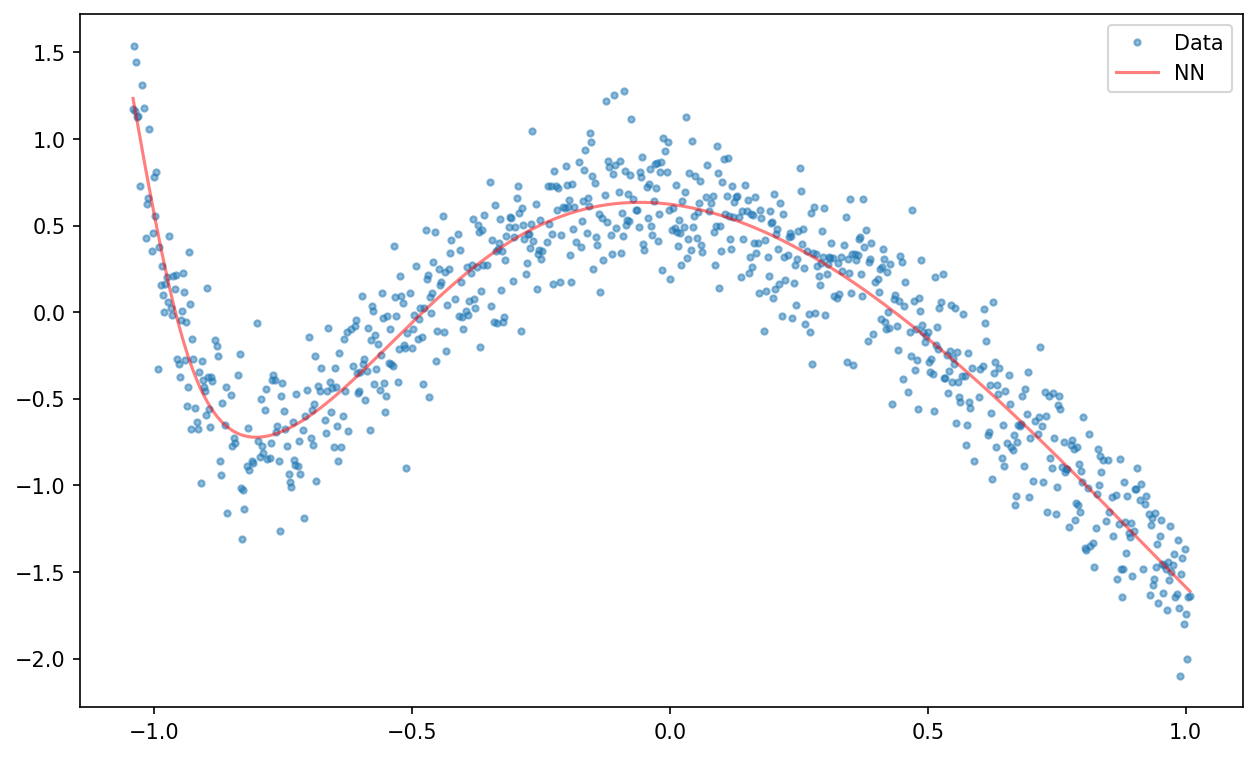

In [53]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.legend()
plt.show()

In [54]:
x_input, y_input, y_output = decoder(model, dl_test)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output])
X_hat = X_hat[X_hat[:,0].argsort()]

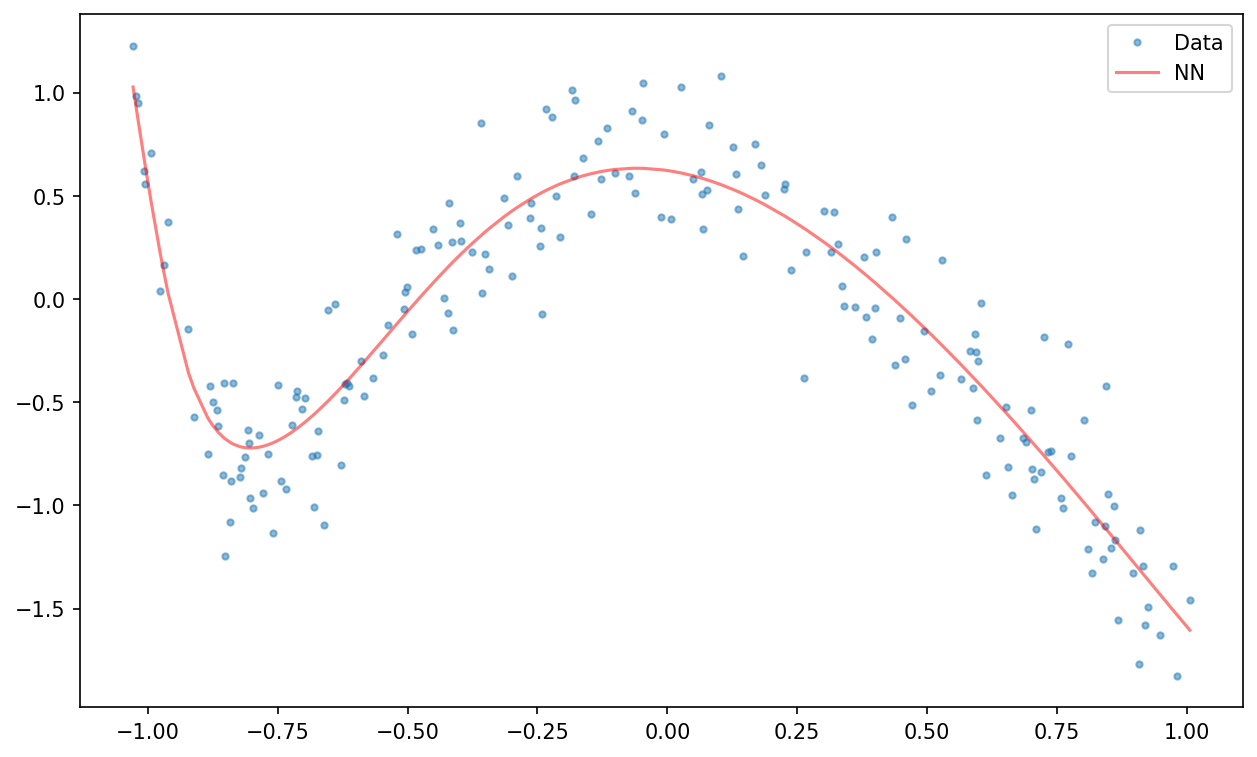

In [55]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.legend()
plt.show()